In [3]:
import numpy as np 
import pandas as pd 

%matplotlib inline
%config InlineBackend.figure_format='retina'  #matplotlib 화질 설정
import matplotlib as mpl
from scipy import stats
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') #한글 깨짐 방지
mpl.rc('axes', unicode_minus=False)       # - 깨짐 방지
plt.style.use('ggplot')
import seaborn as sns

import sqlite3

import warnings
warnings.filterwarnings('ignore')

## Kaggle의 와인 데이터 사용
+ https://www.kaggle.com/datasets/samuelmcguire/wine-reviews-data

    => 비지도학습을 통해 와인 데이터를 군집화해 추천 서비스에 사용할 예정

### features 확인
+ wine : 와인 이름
+ winery : 와인을 만든 양조장
+ category : 레드/화이트 와인 분류
+ designation : 와인을 만든 포도의 원산지 포도밭
+ varietal : 포도의 품종
+ appellation : 와인의 산지
+ alcohol : 알콜 함량
+ price : 와인 한 병의 가격($)
+ rating : 리뷰에 따른 점수
+ reviwer : 리뷰어 이름
+ review : 리뷰

In [6]:
data = pd.read_csv('kaggle_wine.csv', index_col=0).drop_duplicates().reset_index()

print('총 데이터 크기 :', data.shape)
data.head()

총 데이터 크기 : (323204, 11)


,wine,winery,category,designation,varietal,appellation,alcohol,price,rating,reviewer,review
0,J. Lohr 2000 Hilltop Vineyard Cabernet Sauvign...,J. Lohr,Red,Hilltop Vineyard,Cabernet Sauvignon,"Paso Robles, Central Coast, California, US",NaN,$32,87,NaN,"Held back nearly five years, this Cab still ha..."
1,Antucura 2010 Pinot Noir (Vista Flores),Antucura,Red,NaN,Pinot Noir,"Vista Flores, Mendoza Province, Argentina",15%,$17,85,Michael Schachner,"Rubbery, bold and earthy on the nose, then ful..."
2,Quinta do Portal 1999 Quinta do Portal Reserva...,Quinta do Portal,Red,Quinta do Portal Reserva,"Red Blends, Red Blends","Douro, Portugal",NaN,NaN,90,Roger Voss,"Smoky, meaty aromas lead into perfumed fruit f..."
3,Tenuta di Ghizzano 2006 Il Ghizzano Red (Toscana),Tenuta di Ghizzano,Red,Il Ghizzano,"Red Blends, Red Blends","Toscana, Tuscany, Italy",13.5%,$18,86,NaN,The nose is rather neutral save for distant ar...
4,Tenuta San Francesco 2007 Tramonti White (Camp...,Tenuta San Francesco,White,Tramonti,White Blend,"Campania, Southern Italy, Italy",13.5%,$21,85,NaN,"This intriguing blend of Falanghina, Biancolel..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323204 entries, 0 to 323203
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   wine         323204 non-null  object
 1   winery       323204 non-null  object
 2   category     323204 non-null  object
 3   designation  229669 non-null  object
 4   varietal     302159 non-null  object
 5   appellation  320597 non-null  object
 6   alcohol      282207 non-null  object
 7   price        299261 non-null  object
 8   rating       323204 non-null  int64 
 9   reviewer     251055 non-null  object
 10  review       322076 non-null  object
dtypes: int64(1), object(10)
memory usage: 27.1+ MB


## 데이터 전처리
### 1. 결측치

In [ ]:
na = data.isna().sum().sort_values(ascending=False)
percent = round(data.isna().sum() / data.isna().count() * 100, 2).sort_values(ascending=False)

pd.concat([na, percent], axis=1, keys=['NA', 'percent'])
#alcohol, price의 결측치는 총 데이터의 median값으로 채워줄 예정

,NA,percent
designation,93535,28.94
reviewer,72149,22.32
alcohol,40997,12.68
price,23943,7.41
varietal,21045,6.51
appellation,2607,0.81
review,1128,0.35
wine,0,0.00
winery,0,0.00
category,0,0.00


### 2. 분포 및 이상치 확인
+ 연속형 데이터인 경우 분포 확인
+ 범주형 데이터인 경우 class 불균형 확인

count    323204.000000
mean         88.585141
std           3.186520
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: rating, dtype: float64


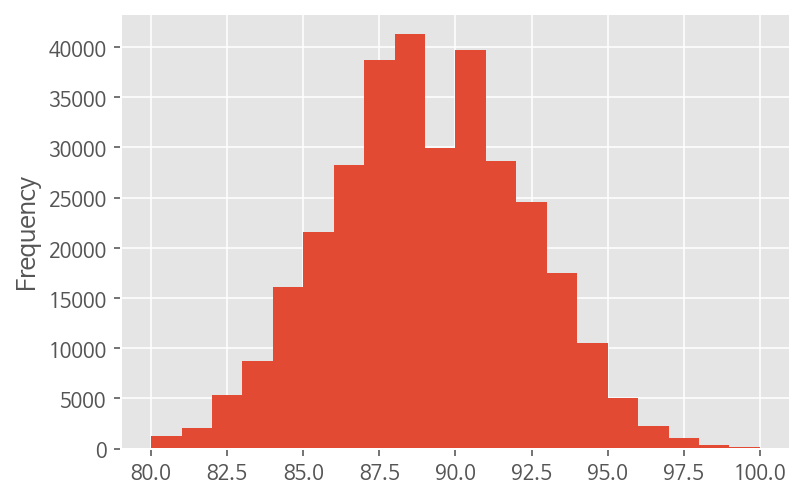

In [ ]:
#1. rating 
print(data.rating.describe())
data.rating.plot(kind='hist', bins=20);
#정규분포를 따르는 것으로 보임

((array([-4.59685206, -4.40844866, -4.30631845, ...,  4.30631845,
          4.40844866,  4.59685206]),
  array([ 80,  80,  80, ..., 100, 100, 100], dtype=int64)),
 (3.1707175548392863, 88.58514127300404, 0.9950276101651939))

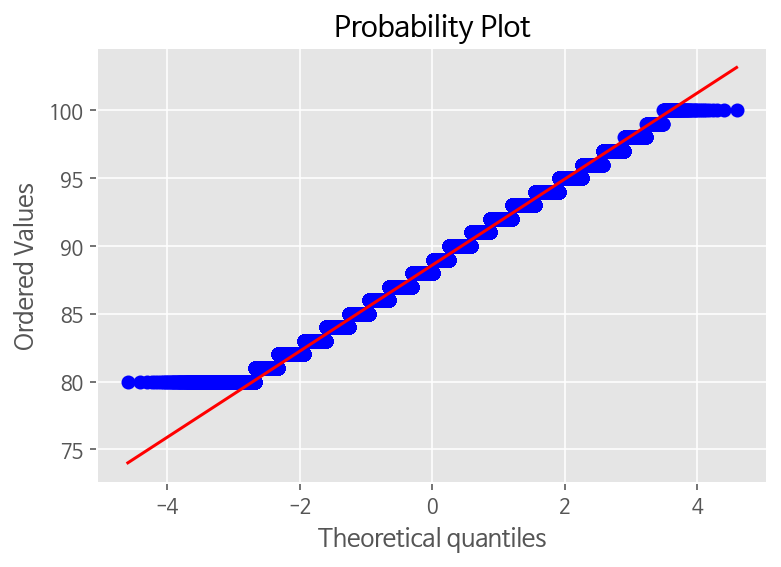

In [ ]:
#QQ Plot 으로도 분포 확인 
plt.figure()
stats.probplot(data.rating, plot=plt)
#light tailed 경향이 있지만 크게 치우치진 않아 보임

In [ ]:
#2. price 
#우선 object => float 형변환
price = []
for i in data['price']:
    if type(i) == float:
        price.append(0)
    elif i[0] != '$':
        price.append(0)
    else:
        price.append(float(i[1:]))
        
data['price'] = price

data.price.describe()

count    323204.000000
mean         32.162893
std          44.337926
min           0.000000
25%          15.000000
50%          24.000000
75%          40.000000
max        8500.000000
Name: price, dtype: float64

In [ ]:
tmp = data.price.median()
price = []
for i in data.price:
    if i == 0:
        price.append(tmp)
    else:
        price.append(i)
        
data['price'] = price

print(data.price.describe())

count    323204.000000
mean         34.478731
std          43.209956
min           3.000000
25%          18.000000
50%          24.000000
75%          40.000000
max        8500.000000
Name: price, dtype: float64


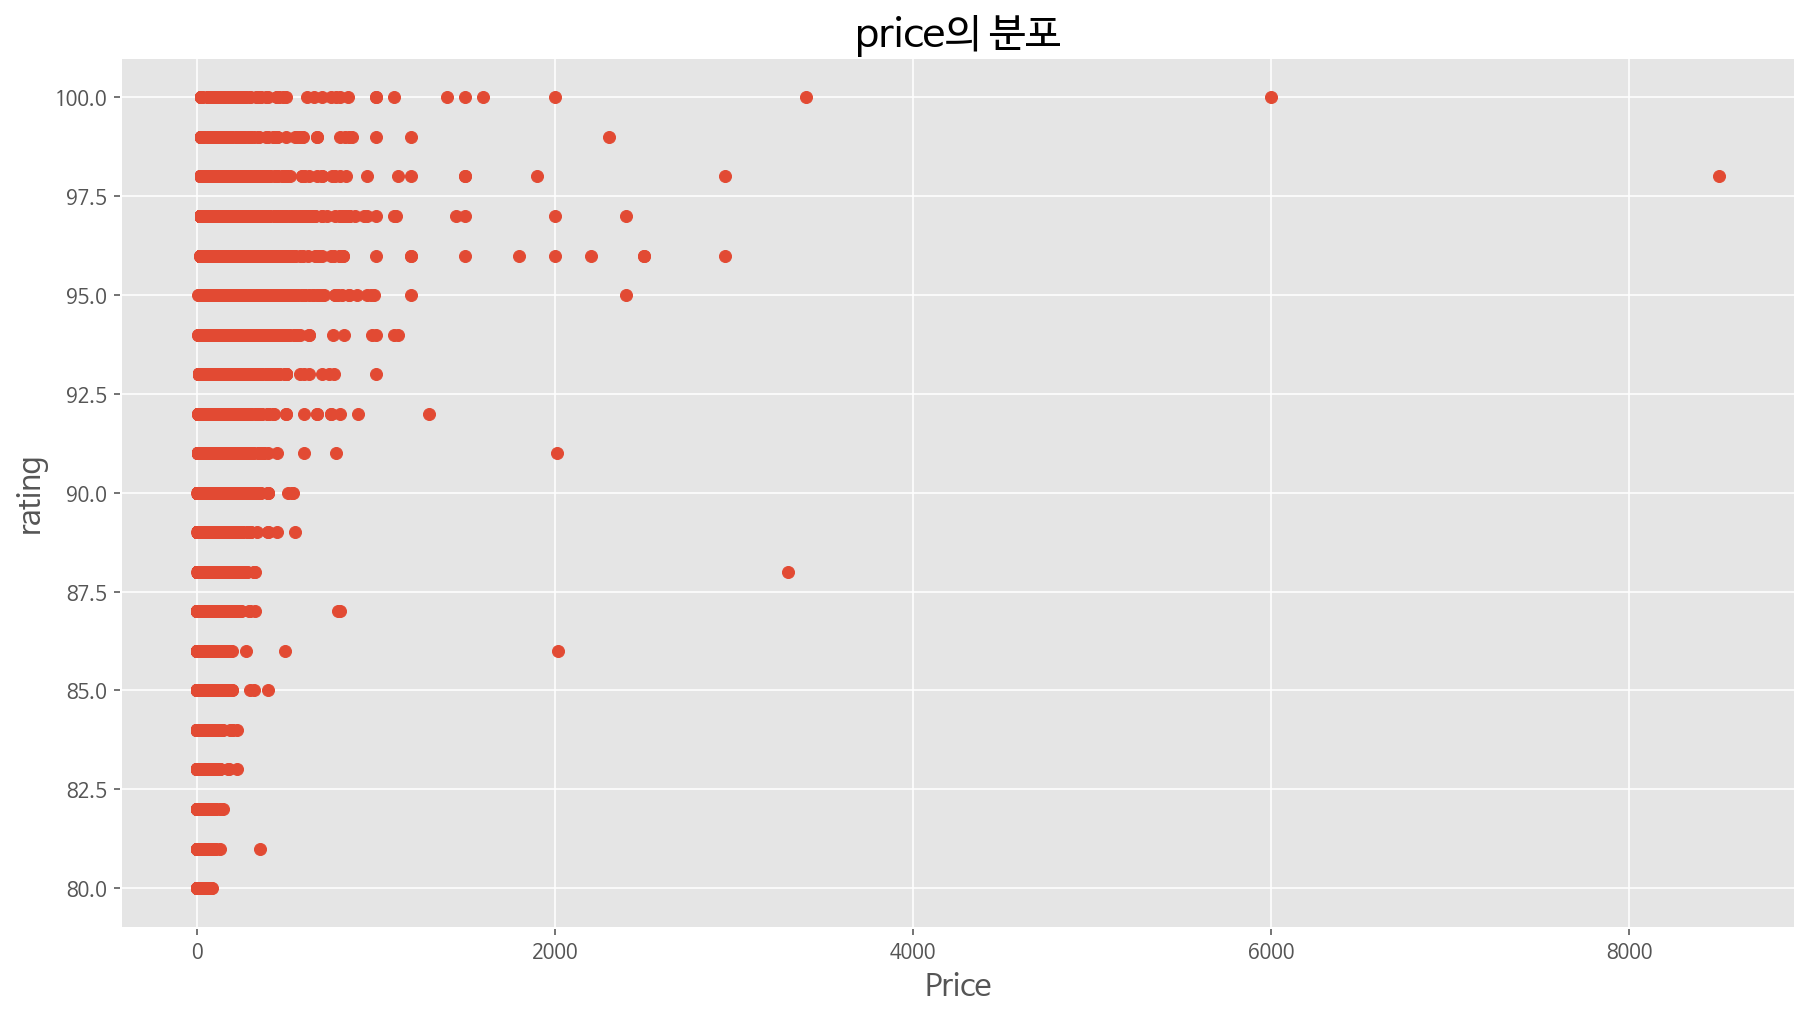

In [ ]:
fig = plt.figure(figsize=(15,8))
plt.scatter(data.price, data.rating)
plt.xlabel('Price', fontsize=15)
plt.ylabel('rating', fontsize=15)
plt.title('price의 분포', fontsize=20);
#평균 $34.47($3-8500)

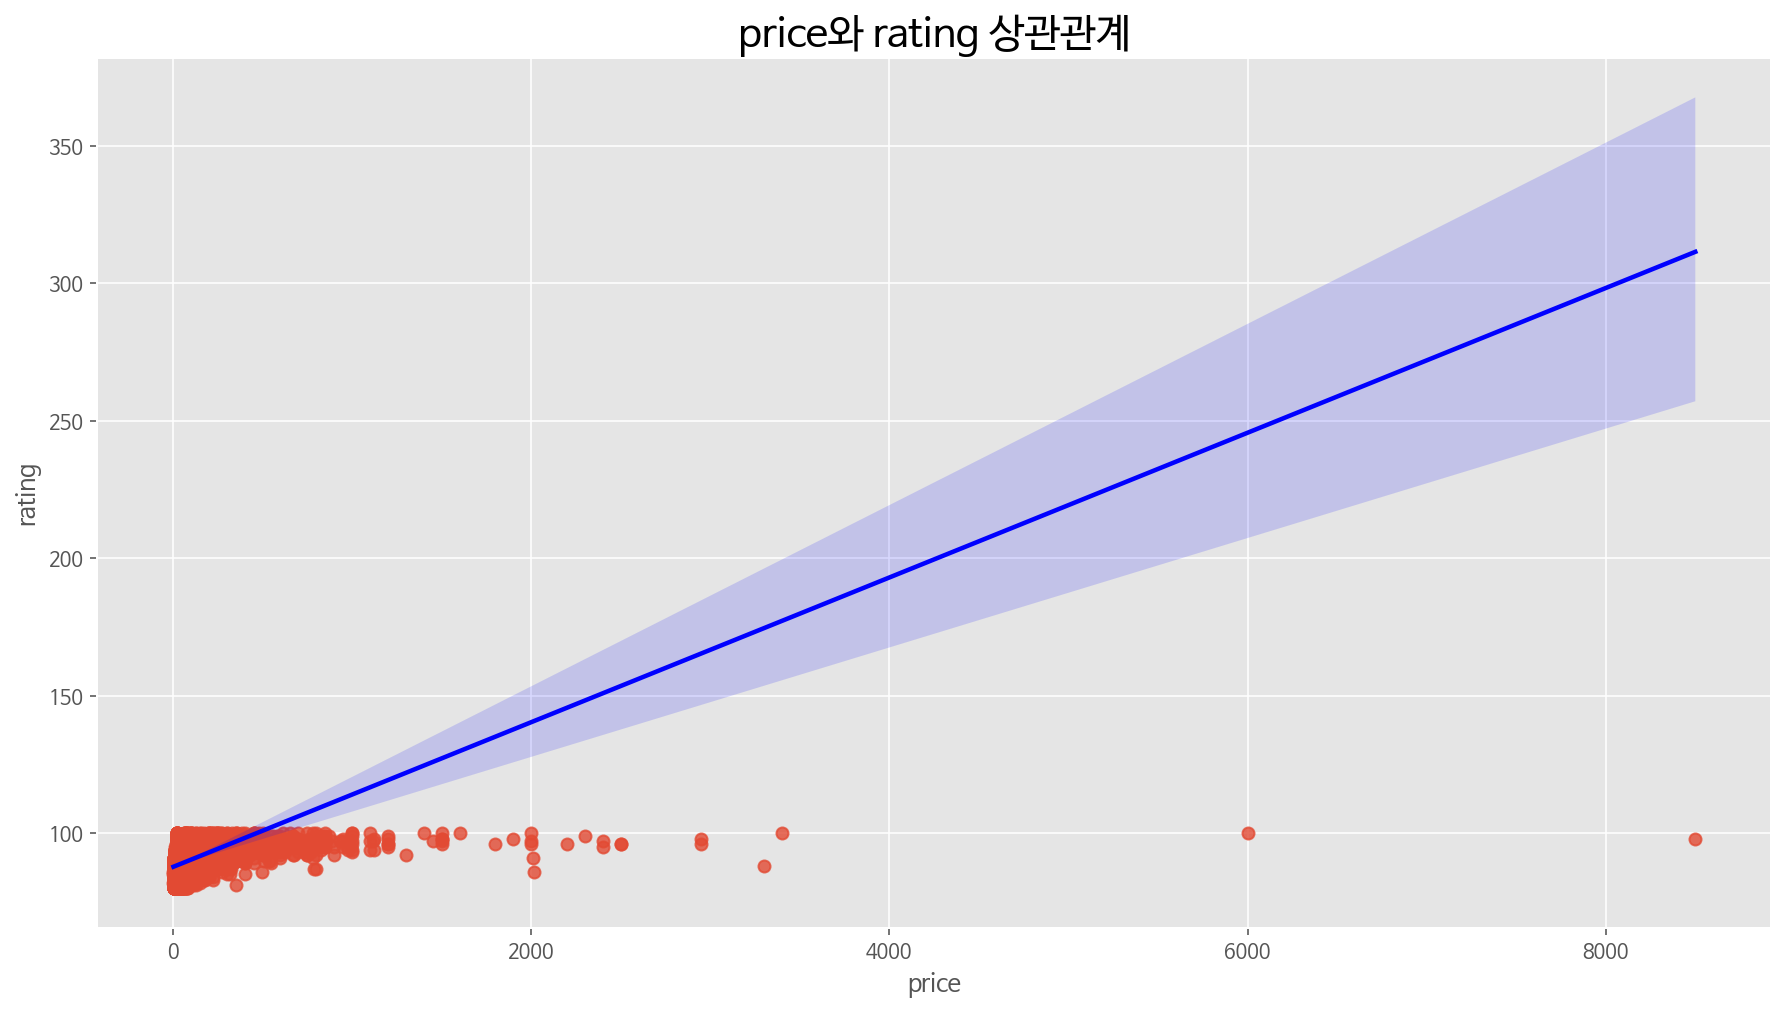

In [ ]:
#price와 points의 상관관계
plt.figure(figsize = (15,8))
sns.regplot(x='price', y='rating', data=data, line_kws={"color": "b"})
plt.title('price와 rating 상관관계', fontsize = 20);
#추세선이 우상향하는 것으로 봐서, 가격이 올라갈수록 평점도 높을 것으로 예상

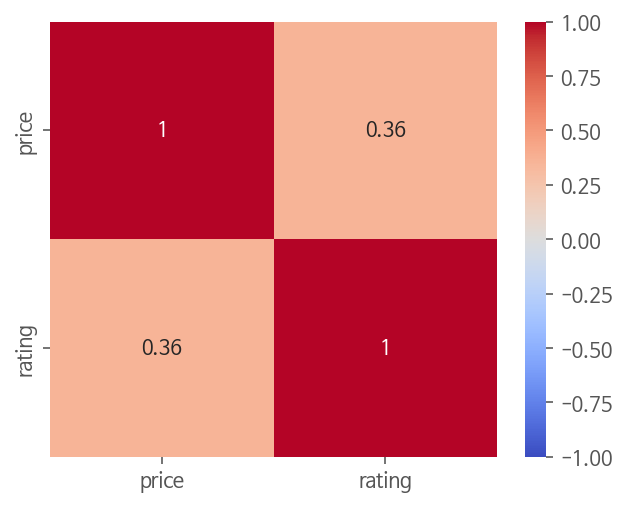

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(data.corr(),
            cmap='coolwarm',
            annot=True,
            vmin=-1);
#상관계수가 0.36로, 약한 양의 상관관계가 있는 것으로 보인다.

In [ ]:
#3. alcohol
#우선 object => float 형변환
percent = []
for i in data['alcohol']:
    if type(i) == float:
        percent.append(0)
    else:
        percent.append(float(i[:-1]))
    
data['alcohol'] = percent

data.alcohol.describe()
#max값이 8333으로 옳지 않은 값.. 와인은 주로 12~15도 정도의 도수로, port wine(브랜드를 첨가한 와인)이 보통 17~20도라고 한다.

count    323204.000000
mean         12.043402
std          24.578557
min           0.000000
25%          12.500000
50%          13.500000
75%          14.200000
max        8333.000000
Name: alcohol, dtype: float64

In [ ]:
len(data[data.alcohol>25])
#넉넉잡아 25도 이상의 와인을 필터링해보니 139개가 나온다. 전체 데이터 중 소수이므로 삭제해도 무방해보인다.

139

In [ ]:
data.drop(data[data.alcohol>25].index, axis=0, inplace=True)
data.alcohol.describe()

count    323065.000000
mean         11.849906
std           4.665732
min           0.000000
25%          12.500000
50%          13.500000
75%          14.200000
max          25.000000
Name: alcohol, dtype: float64

In [ ]:
tmp = data.alcohol.median()
alcohol = []
for i in data.alcohol:
    if i == 0:
        alcohol.append(tmp)
    else:
        alcohol.append(i)
        
data['alcohol'] = alcohol

data.alcohol.describe()

count    323065.000000
mean         13.563058
std           1.166305
min           0.500000
25%          13.000000
50%          13.500000
75%          14.200000
max          25.000000
Name: alcohol, dtype: float64

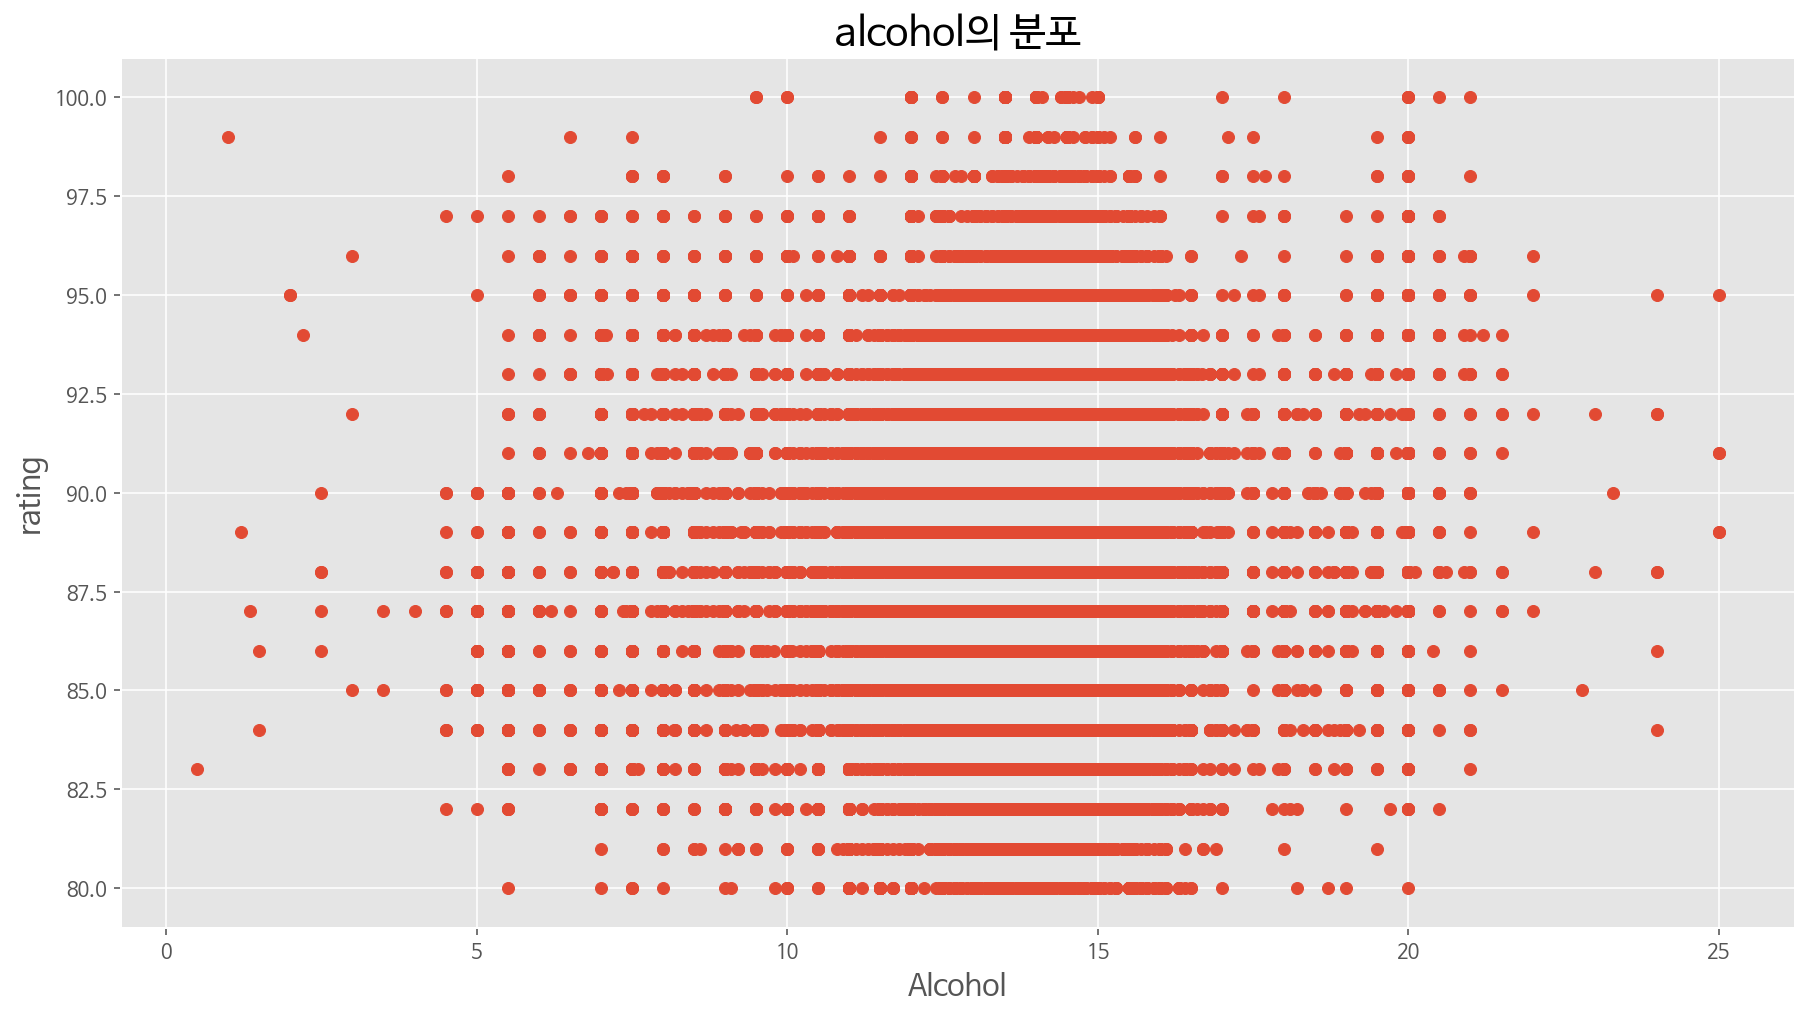

In [ ]:
fig = plt.figure(figsize=(15,8))
plt.scatter(data.alcohol, data.rating)
plt.xlabel('Alcohol', fontsize=15)
plt.ylabel('rating', fontsize=15)
plt.title('alcohol의 분포', fontsize=20);
#평균 13.56%(0.5-25%)

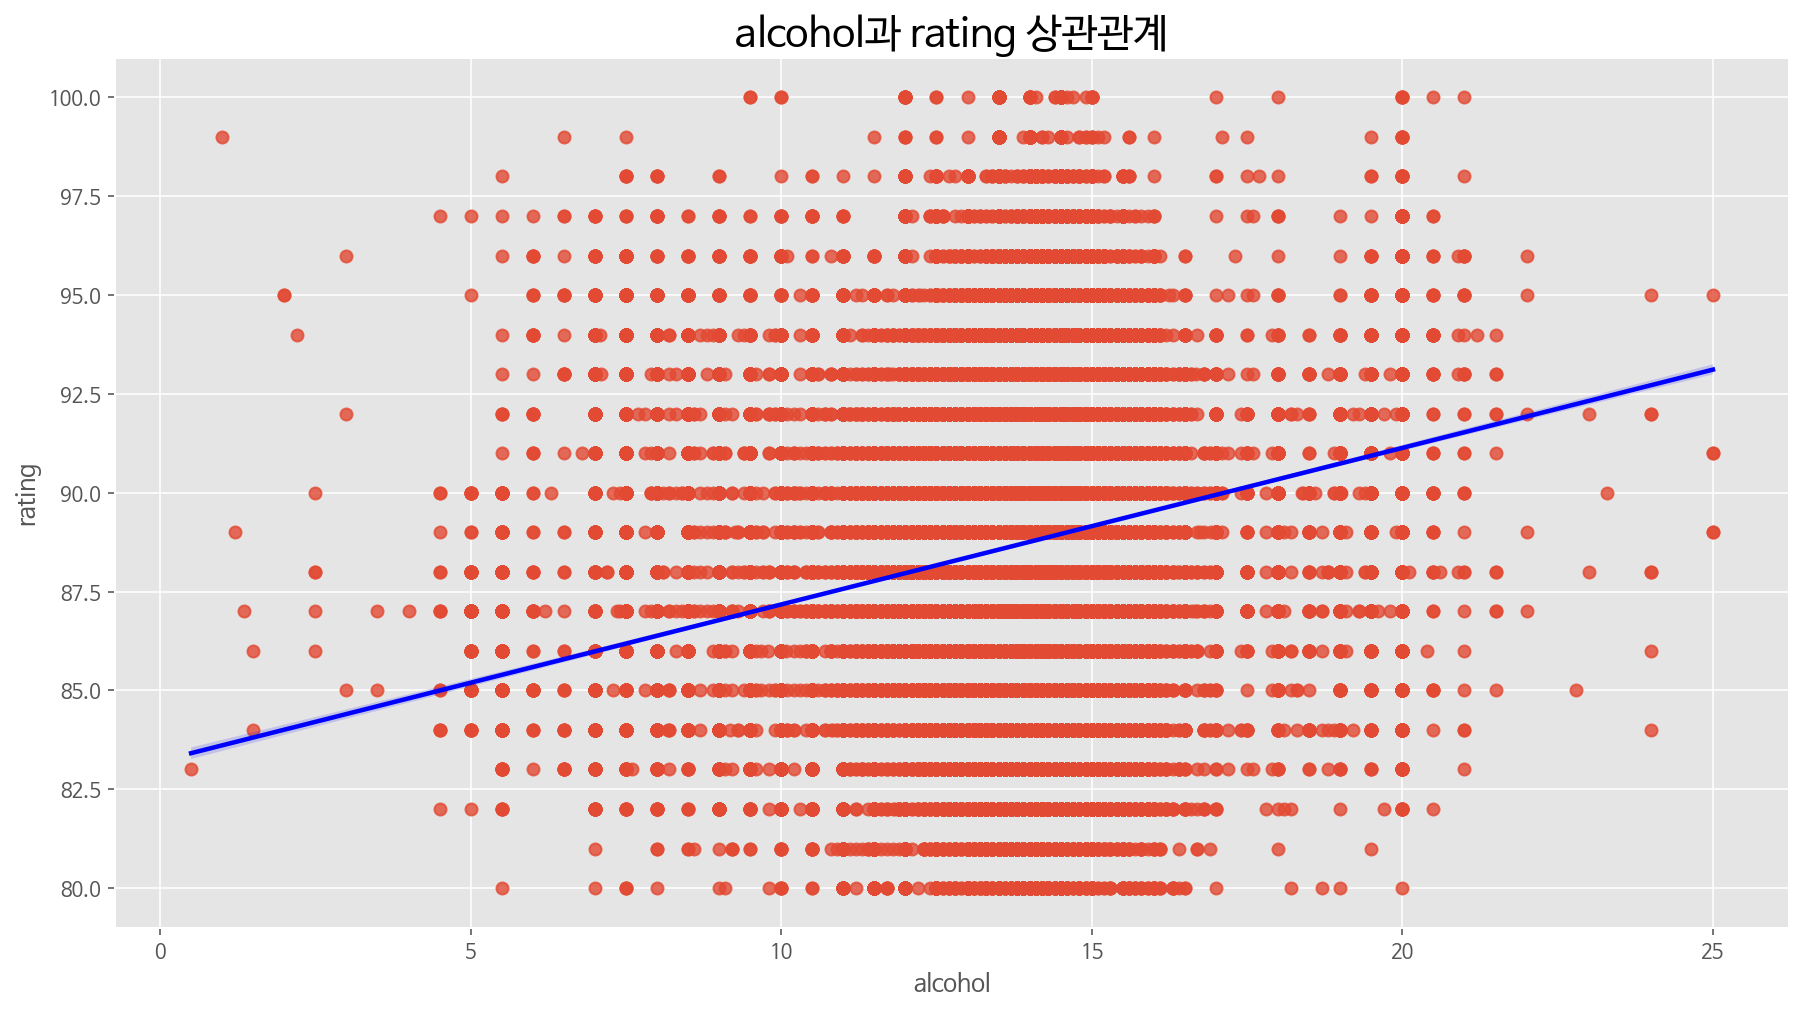

In [ ]:
#alcohol과 points의 상관관계
plt.figure(figsize = (15,8))
sns.regplot(x='alcohol', y='rating', data=data, line_kws={"color": "b"})
plt.title('alcohol과 rating 상관관계', fontsize = 20);
#추세선이 우상향하는 것으로 봐서, 도수가 높아질수록 평점도 높을 것으로 예상(고급와인일수록 도수가 높다고 하던데 확인해보자)

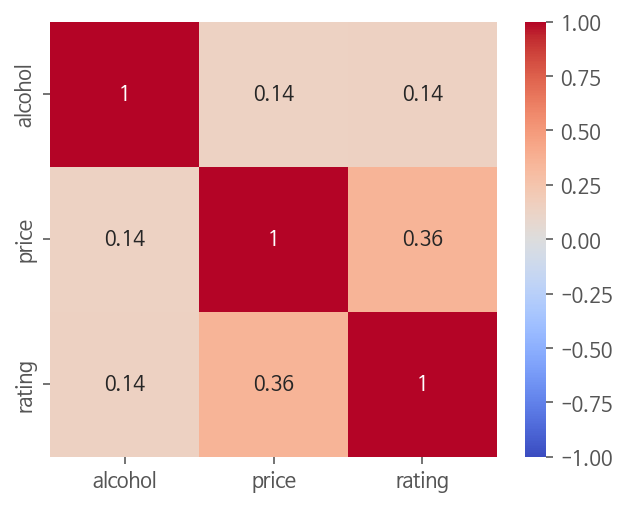

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(data.corr(),
            cmap='coolwarm',
            annot=True,
            vmin=-1);
#상관계수가 0.14로, 상관관계가 매우 낮은 편이다.

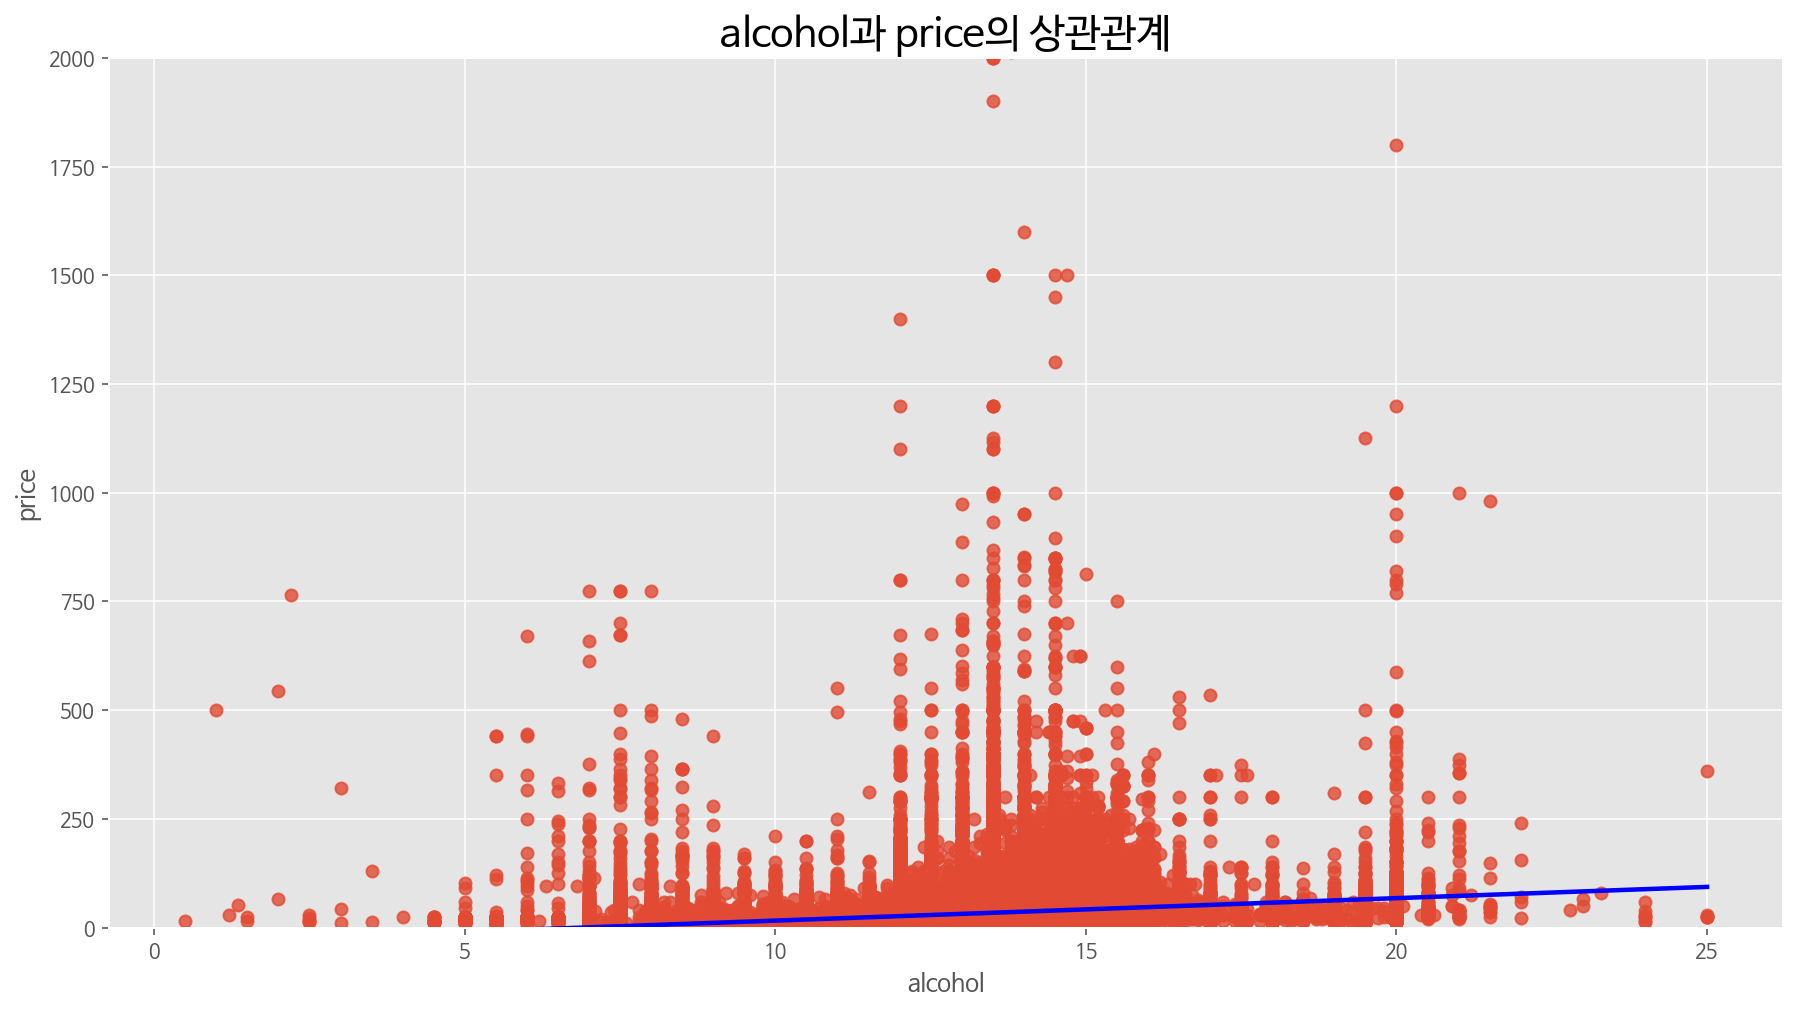

In [ ]:
#alcohol과 price의 상관관계
plt.figure(figsize = (15,8))
sns.regplot(x='alcohol', y='price', data=data, line_kws={"color": "b"})
plt.ylim([0,2000])
plt.title('alcohol과 price의 상관관계', fontsize = 20);
#아주 미세하게 추세선이 우상향하지만, 매우 미미..

In [ ]:
data.head()

,wine,winery,category,designation,varietal,appellation,alcohol,price,rating,reviewer,review
0,J. Lohr 2000 Hilltop Vineyard Cabernet Sauvign...,J. Lohr,Red,Hilltop Vineyard,Cabernet Sauvignon,"Paso Robles, Central Coast, California, US",13.5,32.0,87,NaN,"Held back nearly five years, this Cab still ha..."
1,Antucura 2010 Pinot Noir (Vista Flores),Antucura,Red,NaN,Pinot Noir,"Vista Flores, Mendoza Province, Argentina",15.0,17.0,85,Michael Schachner,"Rubbery, bold and earthy on the nose, then ful..."
2,Quinta do Portal 1999 Quinta do Portal Reserva...,Quinta do Portal,Red,Quinta do Portal Reserva,"Red Blends, Red Blends","Douro, Portugal",13.5,24.0,90,Roger Voss,"Smoky, meaty aromas lead into perfumed fruit f..."
3,Tenuta di Ghizzano 2006 Il Ghizzano Red (Toscana),Tenuta di Ghizzano,Red,Il Ghizzano,"Red Blends, Red Blends","Toscana, Tuscany, Italy",13.5,18.0,86,NaN,The nose is rather neutral save for distant ar...
4,Tenuta San Francesco 2007 Tramonti White (Camp...,Tenuta San Francesco,White,Tramonti,White Blend,"Campania, Southern Italy, Italy",13.5,21.0,85,NaN,"This intriguing blend of Falanghina, Biancolel..."


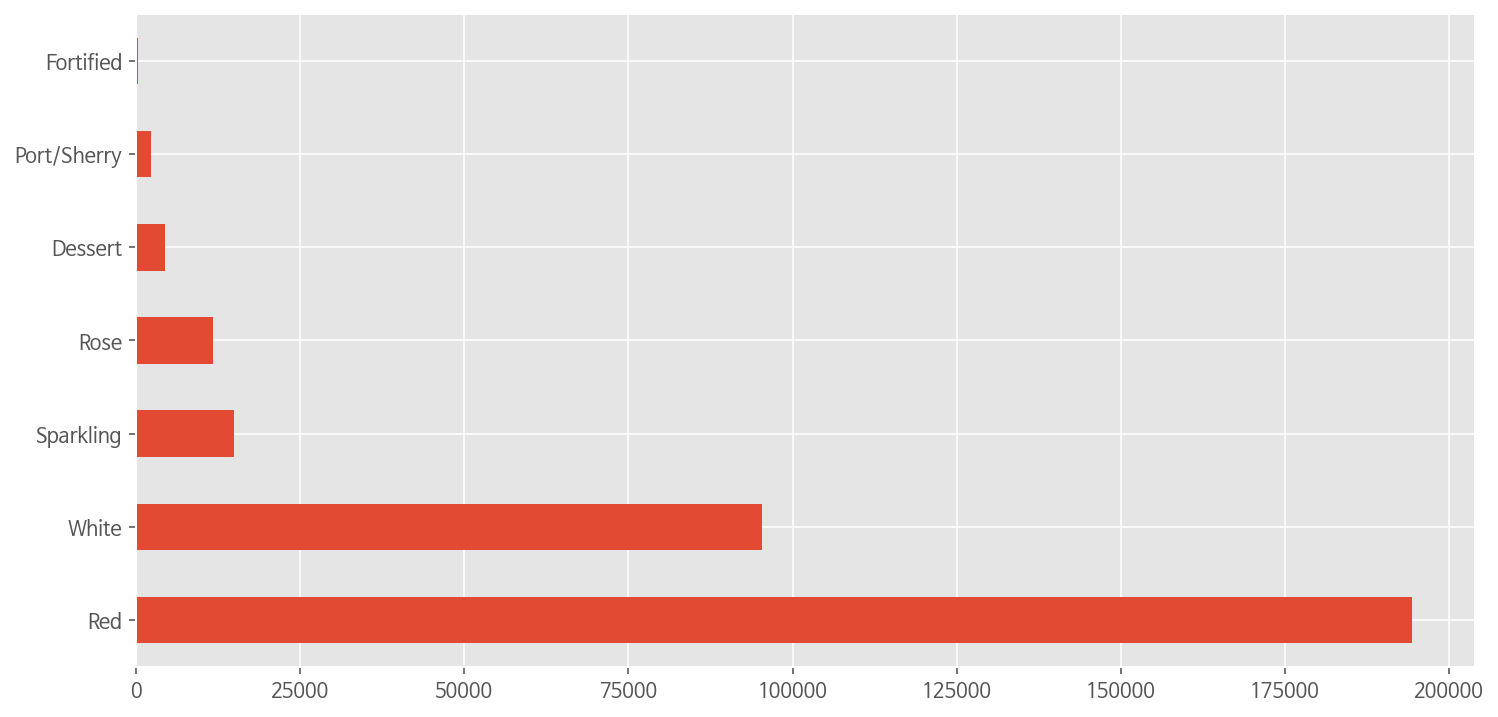

In [ ]:
#4. category
plt.figure(figsize = (12,6))
data.category.value_counts().plot(kind='barh');
#불균형 클래스로, 레드 와인이 압도적으로 많음
#Fortified : 알코올을 타서 독하게 한 와인
#Port/Sherry : 두가지 다 fortified wine의 종류

In [ ]:
#Port/Sherry인 데이터는 Fortified로 합치기
for i, cat in enumerate(data['category']):
    if cat == 'Port/Sherry':
        data.iloc[i,2] = 'Fortified'
        
data.category.value_counts()

Red          194297
White         95376
Sparkling     14927
Rose          11659
Dessert        4325
Fortified      2481
Name: category, dtype: int64

In [ ]:
means = []
for i in data.category.unique():
    means.append(round(data[data.category == i].rating.mean(), 4))
    
df = pd.DataFrame(means, data.category.unique(), columns=['카테고리별 평균점수'])
df = df.sort_values(by=['카테고리별 평균점수'], ascending=False)

df

,카테고리별 평균점수
Dessert,90.0018
Fortified,89.7437
Red,88.8020
Sparkling,88.6730
White,88.2141
Rose,87.1160


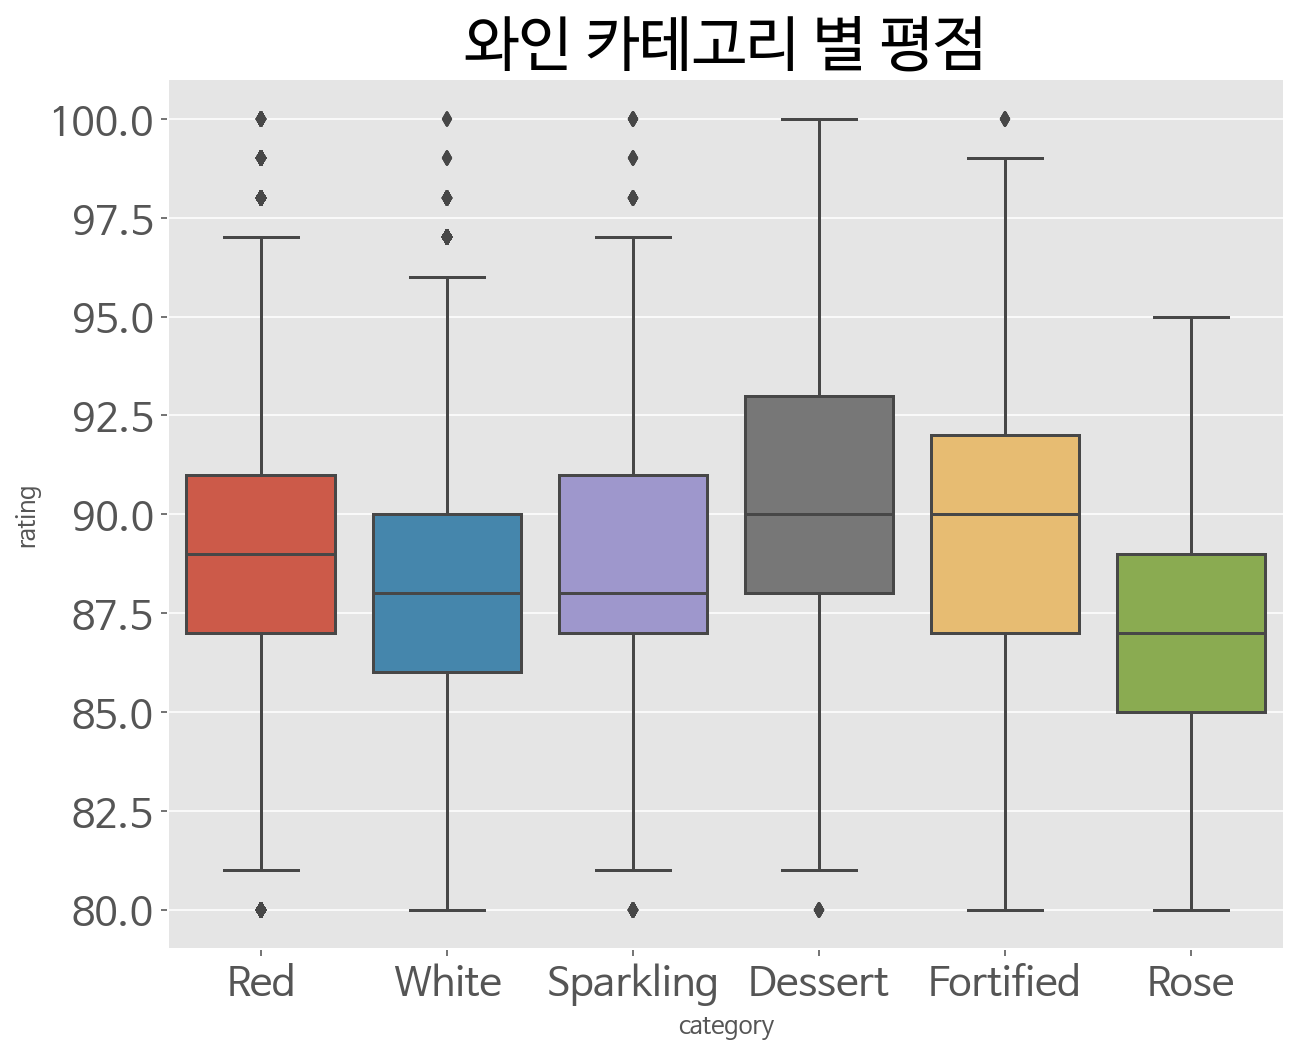

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.title('와인 카테고리 별 평점', fontsize=30)
sns.boxplot(x='category', y='rating', data=data)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

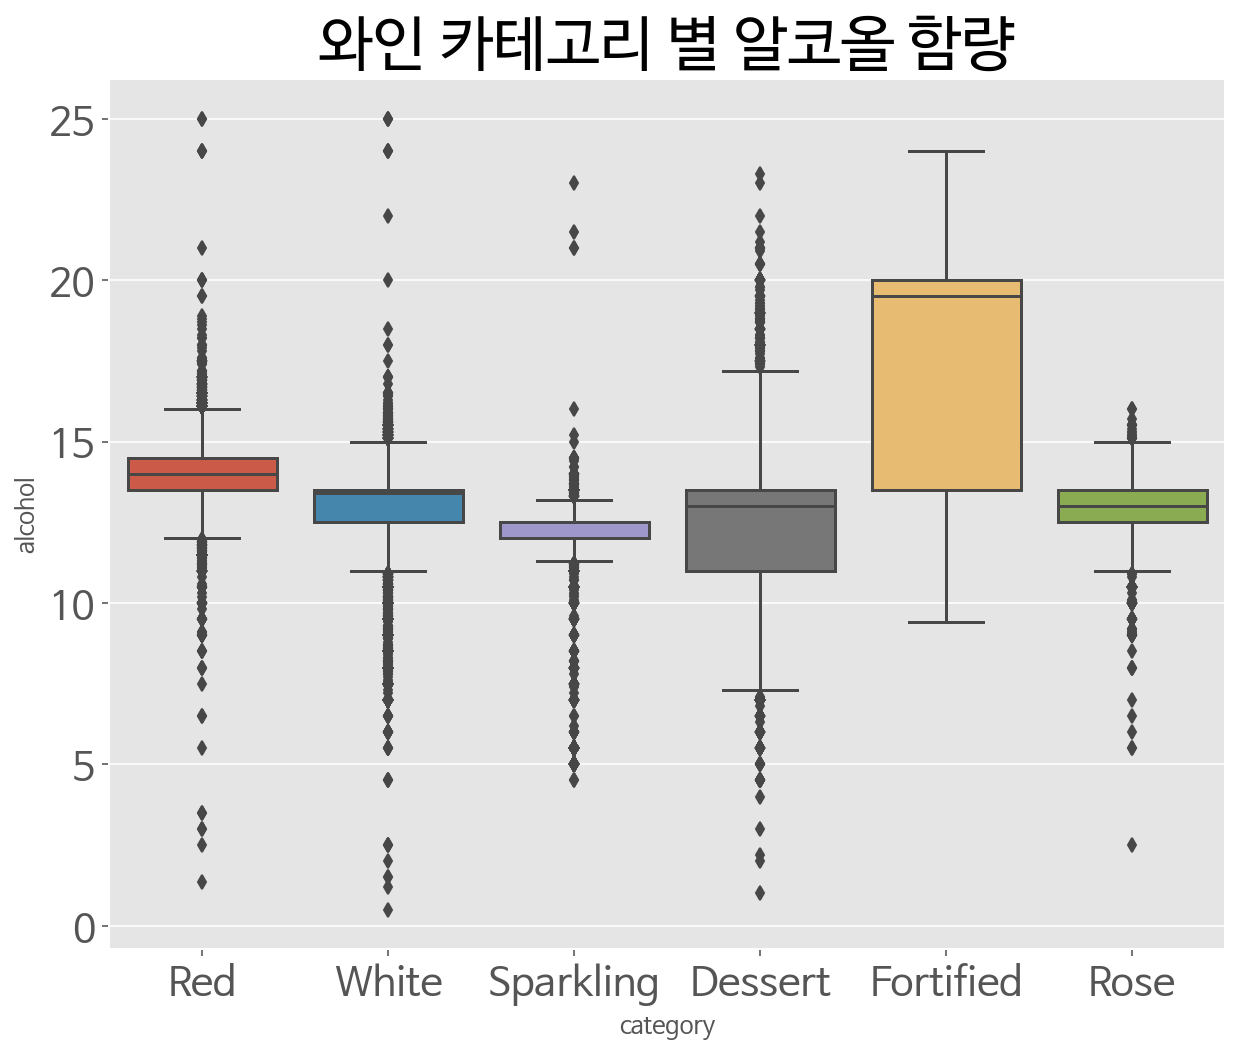

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.title('와인 카테고리 별 알코올 함량', fontsize=30)
sns.boxplot(x='category', y='alcohol', data=data)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [ ]:
#5. varietal
data.varietal.value_counts()
#869 class

Pinot Noir                                 33516
Chardonnay                                 29428
Cabernet Sauvignon                         23819
Red Blends, Red Blends                     20006
Bordeaux-style Red Blend                   17835
                                           ...  
Ruen, Other Red                                1
Assyrtiko-Sauvignon Blanc, White Blend         1
Chardonel, Other White                         1
Grasparossa di Castelvetro, Italian Red        1
Ehrenfelser, Other White                       1
Name: varietal, Length: 869, dtype: int64

In [ ]:
#6. appellation
data.appellation.value_counts()
#2003 class

Napa Valley, Napa, California, US                             11470
Columbia Valley (WA), Columbia Valley, Washington, US          9148
California, California Other, California, US                   7407
Russian River Valley, Sonoma, California, US                   7159
Paso Robles, Central Coast, California, US                     6098
                                                              ...  
Vino de la Tierra Ribera del Jiloca, Northern Spain, Spain        1
Deutscher Tafelwein Rhein, Germany                                1
Rosso di Cerignola, Southern Italy, Italy                         1
Barkan, Israel                                                    1
Delia Nivolelli, Sicily & Sardinia, Italy                         1
Name: appellation, Length: 2003, dtype: int64

In [ ]:
#국가만 뽑아보자
country_list = []
for i in data.appellation:
    if type(i) == float:
        country_list.append(i)
    else:
        appel = i.split(',')
        country = appel[-1]
        if country[0] == ' ':
            country_list.append(country[1:])
        else:
            country_list.append(country)
data['country'] = country_list
data.country.value_counts()

US              135224
France           59670
Italy            44831
Spain            14936
Portugal         13283
Australia         9592
Chile             9535
Argentina         8739
Austria           7090
Germany           5554
New Zealand       4586
South Africa      3793
Israel            1196
Greece            1157
Buy Now            607
Hungary            333
Romania            330
DrizlyVivino         2
Name: country, dtype: int64

In [ ]:
means = []
for i in data.country.unique():
    means.append(round(data[data.country == i].rating.mean(), 4))
    
df = pd.DataFrame(means, data.country.unique(), columns=['국가별 평균점수'])
df = df.sort_values(by=['국가별 평균점수'], ascending=False)

df

,국가별 평균점수
Austria,90.5282
Germany,89.5448
France,89.3056
Hungary,89.1411
Italy,88.7748
US,88.6197
Portugal,88.5657
Israel,88.3211
Australia,88.0880
New Zealand,88.0251


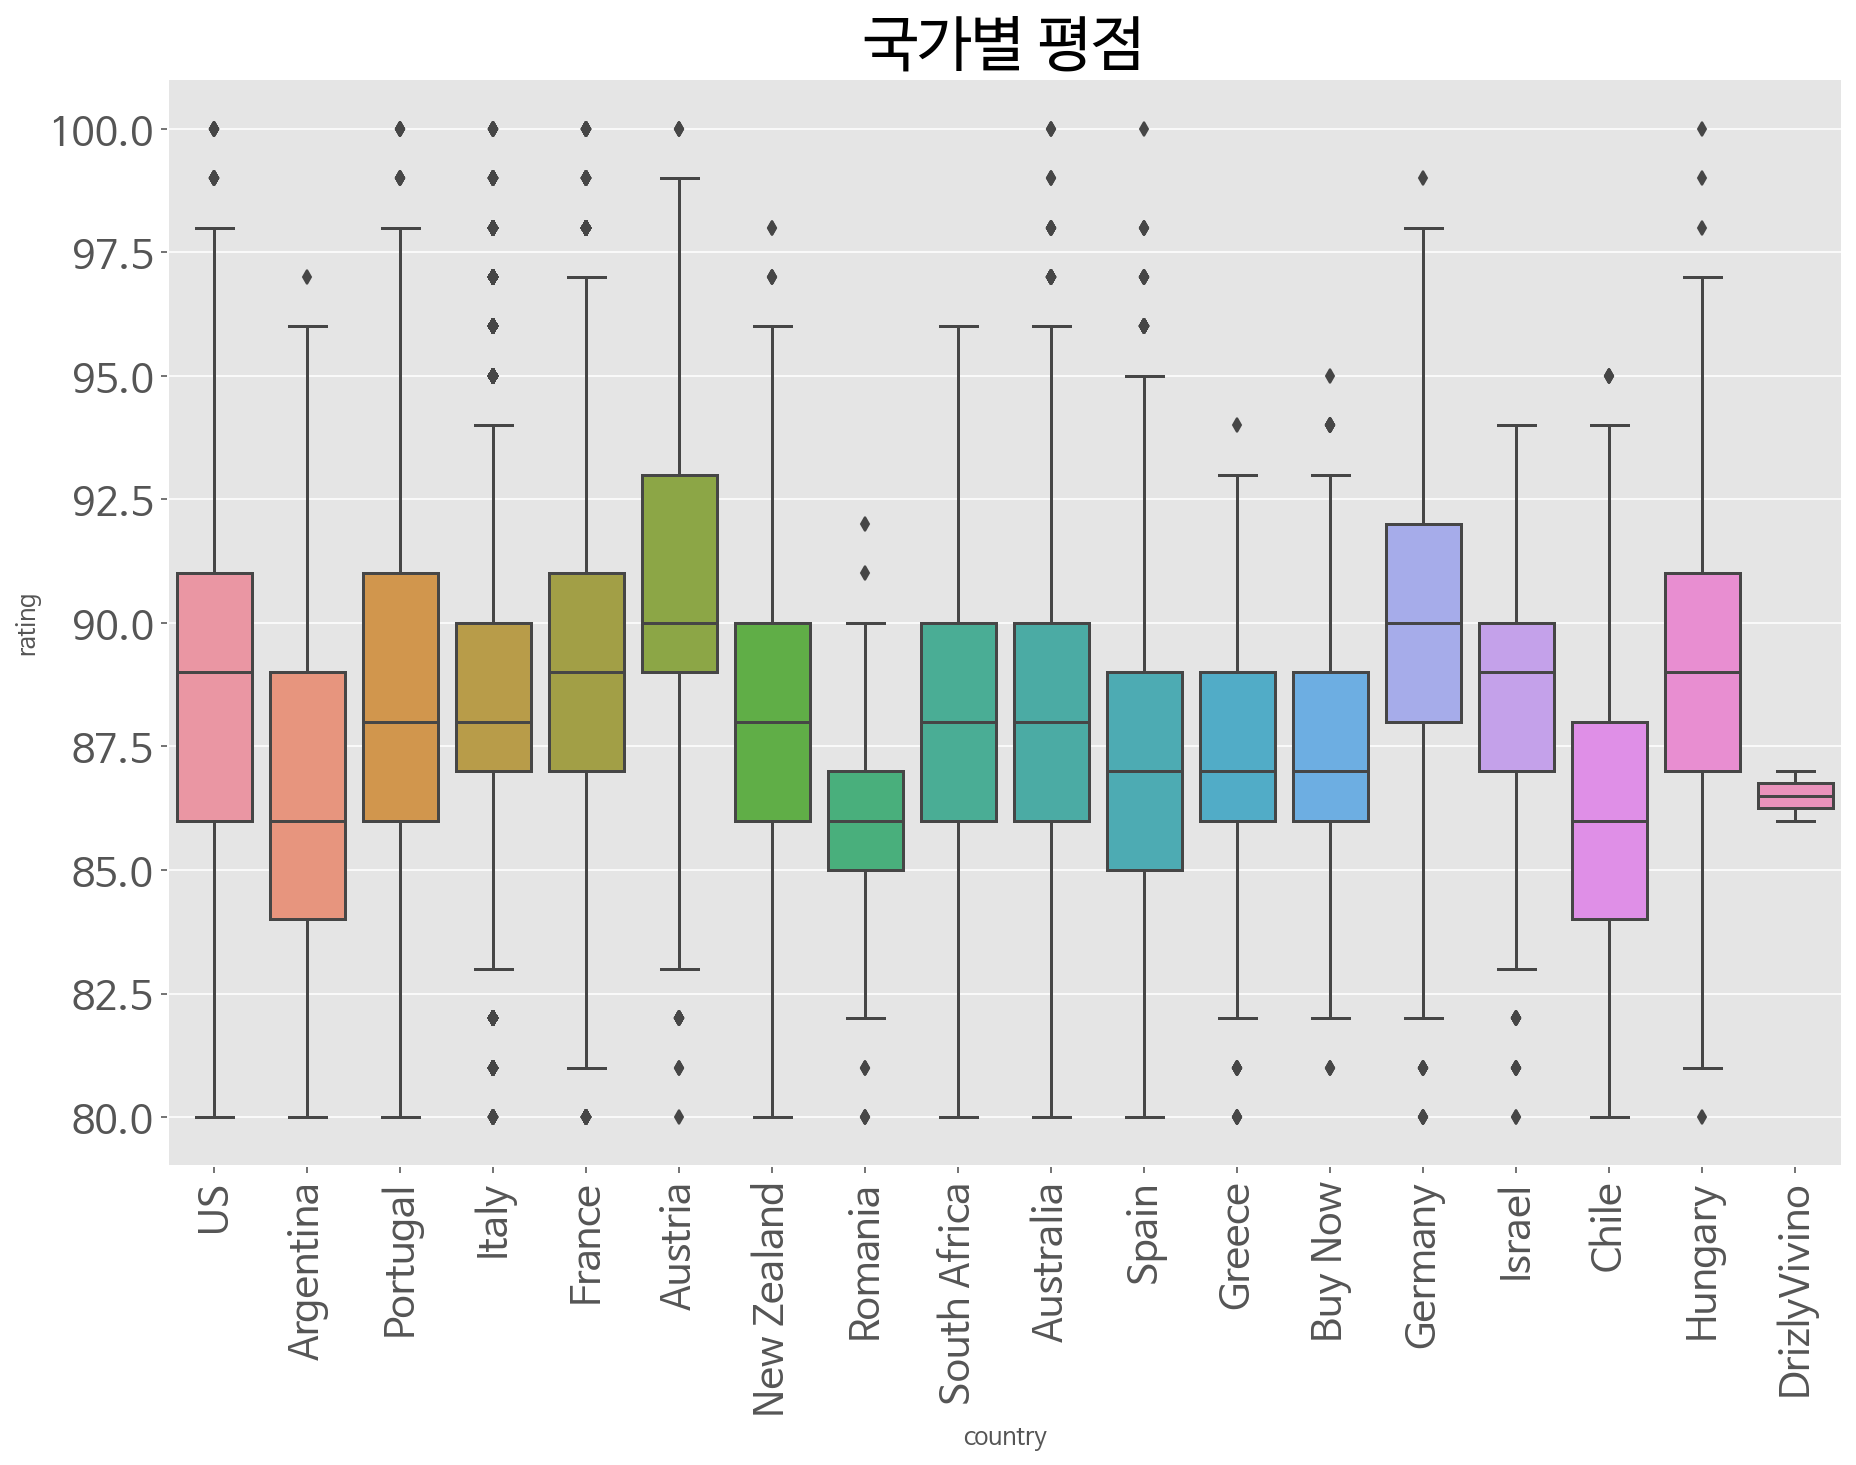

In [ ]:
fig = plt.figure(figsize=(15,10))
plt.title('국가별 평점', fontsize=30)
sns.boxplot(x='country', y='rating', data=data)
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)
plt.show()

In [ ]:
#국가보다 세부지역들도 나눠서 column으로 저장
region_1, region_2, region_3, region_4 = [], [], [], []
for i in data.appellation:
    if type(i) == float:
        region_1.append(None)
        region_2.append(None)
        region_3.append(None)
        region_4.append(None)
    else:
        region = i.split(',')
        try:
            if region[-2][0] == ' ':
                region_1.append(region[-2][1:])
            else: region_1.append(region[-2])
        except:
            region_1.append(None)
        try:        
            if region[-3][0] == ' ':
                region_2.append(region[-3][1:])
            else: region_2.append(region[-3])
        except:
            region_2.append(None)
        try: 
            if region[-4][0] == ' ':
                region_3.append(region[-4][1:])
            else: region_3.append(region[-4])
        except:
            region_3.append(None)
        try:
            if region[-5][0] == ' ':
                region_4.append(region[-5][1:])
            region_4.append(region[-5])
        except:
            region_4.append(None)
            
len(region_1), len(region_2), len(region_3), len(region_4)

(323065, 323065, 323065, 323065)

In [ ]:
data['region_1'] = region_1
data['region_2'] = region_2
data['region_3'] = region_3
data['region_4'] = region_4

In [ ]:
#7. reviewer
data.reviewer.value_counts

<bound method IndexOpsMixin.value_counts of 0                       NaN
1         Michael Schachner
2                Roger Voss
3                       NaN
4                       NaN
                ...        
323199        Matt Kettmann
323200        Kerin O’Keefe
323201     Anne Krebiehl MW
323202     Sean P. Sullivan
323203                  NaN
Name: reviewer, Length: 323065, dtype: object>

In [ ]:
#가장 평점이 후한 리뷰어 10명
means = []
for i in data.reviewer.unique():
    means.append(round(data[data.reviewer == i].rating.mean(), 4))
    
df = pd.DataFrame(means, data.reviewer.unique(), columns=['리뷰어별 평균점수'])
nice_df = df.sort_values(by=['리뷰어별 평균점수'], ascending=False).head(10)
poor_df = df.sort_values(by=['리뷰어별 평균점수'], ascending=True).head(10)

nice_df

,리뷰어별 평균점수
Dara Kapoor,93.0000
Layla Schlack,91.5455
Anne Krebiehl MW,91.1229
Matt Kettmann,90.3944
Virginie Boone,89.8142
Anna Lee C. Iijima,89.6510
Kerin O’Keefe,89.4013
Christina Pickard,89.3885
Paul Gregutt,89.1827
Roger Voss,89.1296


In [ ]:
poor_df

,리뷰어별 평균점수
Jesica Vargas,85.2628
Susan Kostrzewa,86.4535
Fiona Adams,86.7763
Michael Schachner,86.7901
Carrie Dykes,86.8953
Alexander Peartree,87.7060
Joe Czerwinski,87.7413
Lauren Buzzeo,88.0005
Jeff Jenssen,88.2175
Jim Gordon,88.8077


In [ ]:
data.to_csv('wine.csv')